In [1]:
#!pip3 install opencv-python
import numpy as np
import cv2
import matplotlib.pyplot as plt

## 1. Load the datasets

For the project, we provide a training set with 50000 images in the directory `../data/images/` with:
- noisy labels for all images provided in `../data/noisy_label.csv`;
- clean labels for the first 10000 images provided in `../data/clean_labels.csv`. 

In [2]:
# load the labels
clean_labels = np.genfromtxt('../data/clean_labels.csv', delimiter=',', dtype="int8")
noisy_labels = np.genfromtxt('../data/noisy_labels.csv', delimiter=',', dtype="int8", skip_header=10000)
# Reading the remaining 40000 labels, excluding the first 10000 labels
print(noisy_labels[:3])

[1 7 3]


In [3]:
# load the images
n_img = 50000
all_imgs = np.empty((n_img, 32, 32, 3))

for i in range(n_img):
    img_fn = f'../data/images/{i+1:05d}.png'
    all_imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)

In [4]:
clean_imgs = all_imgs[:10000,:,:,:]
noisy_imgs = all_imgs[10000:,:,:,:]

print(clean_imgs.shape, noisy_imgs.shape)

(10000, 32, 32, 3) (40000, 32, 32, 3)


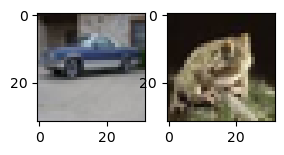

In [5]:
# Show first 2 images of noisy data
fig = plt.figure()

ax1 = fig.add_subplot(2,4,1)
ax1.imshow(noisy_imgs[0]/255)
ax2 = fig.add_subplot(2,4,2)
ax2.imshow(noisy_imgs[1]/255)

## 2. Data Pre-processing

In [6]:
# Normalize all the images

# noisy_imgs = noisy_imgs/255.0
# clean_imgs = clean_imgs/255.0

In [7]:
# Now comes the most essential step of pre-processing, which is applicable only in this case as we aim to use 
# machine learning for image classification. As we will be using the ML algorithms from sklearn, there is a need 
# to reshape the images of the dataset to a two-dimensional array. This is because sklearn expects a 2D array as 
# input to the fit() function which will be called on the model during training. Thus, the images of the test 
# dataset should also be resized to 2D arrays as the model will be trained with this input shape.

In [8]:
# Method 1
# nsamples, nx, ny, nrgb = noisy_imgs.shape
# imgs_train = noisy_imgs.reshape((nsamples,nx*ny*nrgb))
# print(imgs_train.shape)

# nsamples, nx, ny, nrgb = clean_imgs.shape
# imgs_test = clean_imgs.reshape((nsamples,nx*ny*nrgb))
# print(imgs_test.shape)

In [9]:
# Method 2

# RGB histogram dataset construction - train data

no_bins_train = 6
bins_train = np.linspace(0, 255, no_bins_train) # the range of the rgb histogram
img_feature_train = np.empty((noisy_imgs.shape[0], 3*(len(bins_train)-1)))
i = 0

for i in range(noisy_imgs.shape[0]):
    
    # Use the numbers of pixels in each bin for all three channels as the features
    feature1_tr = np.histogram(noisy_imgs[i][:,:,0],bins=bins_train)[0] 
    feature2_tr = np.histogram(noisy_imgs[i][:,:,1],bins=bins_train)[0]
    feature3_tr = np.histogram(noisy_imgs[i][:,:,2],bins=bins_train)[0]
    
    # Concatenate three features
    img_feature_train[i,] = np.concatenate((feature1_tr, feature2_tr, feature3_tr), axis=None)
    i += 1
    

# RGB histogram dataset construction - test data
no_bins_test = 6
bins_test = np.linspace(0, 255, no_bins_test) # the range of the rgb histogram
img_feature_test = np.empty((clean_imgs.shape[0], 3*(len(bins_test)-1)))
i = 0

for i in range(clean_imgs.shape[0]):
    
    # Use the numbers of pixels in each bin for all three channels as the features
    feature1_ts = np.histogram(clean_imgs[i][:,:,0],bins=bins_test)[0] 
    feature2_ts = np.histogram(clean_imgs[i][:,:,1],bins=bins_test)[0]
    feature3_ts = np.histogram(clean_imgs[i][:,:,2],bins=bins_test)[0]
    
    # Concatenate three features
    img_feature_test[i,] = np.concatenate((feature1_ts, feature2_ts, feature3_ts), axis=None)
    i += 1

## 3. Modelling

### Implementing Logistic Regression

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [11]:
# Train

lr_model = LogisticRegression(random_state=0).fit(img_feature_train, noisy_labels)

# Predict
pred_lr_test= lr_model.predict(img_feature_test)

# Evaluate
print(classification_report(pred_lr_test, clean_labels)) # accuracy = 0.24

              precision    recall  f1-score   support

           0       0.41      0.32      0.36      1299
           1       0.29      0.19      0.23      1508
           2       0.06      0.20      0.09       288
           3       0.09      0.19      0.12       487
           4       0.48      0.24      0.32      1969
           5       0.17      0.21      0.19       731
           6       0.34      0.26      0.30      1369
           7       0.03      0.26      0.05       111
           8       0.43      0.28      0.34      1584
           9       0.13      0.19      0.15       654

    accuracy                           0.24     10000
   macro avg       0.24      0.23      0.21     10000
weighted avg       0.33      0.24      0.27     10000



### Implementing a Decision Tree

In [12]:
from sklearn.tree import DecisionTreeClassifier

In [13]:
# Train

dt_model = DecisionTreeClassifier(random_state=0).fit(img_feature_train, noisy_labels)

# Predict
pred_dt_test= dt_model.predict(img_feature_test)

# Evaluate
print(classification_report(pred_dt_test, clean_labels)) # accuracy = 0.14

              precision    recall  f1-score   support

           0       0.17      0.17      0.17       992
           1       0.12      0.12      0.12       999
           2       0.15      0.15      0.15      1015
           3       0.10      0.11      0.11       936
           4       0.15      0.14      0.14      1062
           5       0.13      0.12      0.12      1039
           6       0.13      0.13      0.13      1019
           7       0.15      0.15      0.15       971
           8       0.15      0.16      0.15       966
           9       0.15      0.15      0.15      1001

    accuracy                           0.14     10000
   macro avg       0.14      0.14      0.14     10000
weighted avg       0.14      0.14      0.14     10000



### Implementing a Random Forest Classifier

In [14]:
from sklearn.ensemble import RandomForestClassifier

In [15]:
# Train

rf_model = RandomForestClassifier(random_state=0).fit(img_feature_train, noisy_labels)

# Predict
pred_rf_test= rf_model.predict(img_feature_test)

# Evaluate
print(classification_report(pred_rf_test, clean_labels)) # accuracy = 0.26

              precision    recall  f1-score   support

           0       0.35      0.34      0.35      1015
           1       0.32      0.26      0.29      1188
           2       0.19      0.22      0.20       908
           3       0.14      0.16      0.15       924
           4       0.26      0.23      0.25      1142
           5       0.19      0.19      0.19       957
           6       0.30      0.29      0.29      1059
           7       0.22      0.25      0.23       891
           8       0.29      0.32      0.30       935
           9       0.29      0.29      0.29       981

    accuracy                           0.26     10000
   macro avg       0.26      0.25      0.25     10000
weighted avg       0.26      0.26      0.26     10000



### Implementing a KNN

In [16]:
from sklearn.neighbors import KNeighborsClassifier

In [17]:
# Train

knn_model = KNeighborsClassifier(n_neighbors = 20).fit(img_feature_train, noisy_labels)

# Predict
pred_knn_test= knn_model.predict(img_feature_test)

# Evaluate
print(classification_report(pred_knn_test, clean_labels)) # accuracy = 0.21

/Users/srushtisanghavi/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


              precision    recall  f1-score   support

           0       0.34      0.27      0.30      1237
           1       0.31      0.20      0.24      1546
           2       0.21      0.19      0.20      1101
           3       0.15      0.15      0.15      1030
           4       0.20      0.20      0.20       967
           5       0.15      0.15      0.15       900
           6       0.23      0.25      0.24       946
           7       0.15      0.22      0.18       706
           8       0.21      0.27      0.24       784
           9       0.19      0.24      0.21       783

    accuracy                           0.21     10000
   macro avg       0.21      0.21      0.21     10000
weighted avg       0.22      0.21      0.22     10000



### Implementing a Naive Bayes classifier

In [18]:
from sklearn.naive_bayes import GaussianNB

In [19]:
# Train

nb_model = GaussianNB().fit(img_feature_train, noisy_labels)

# Predict
pred_nb_test= nb_model.predict(img_feature_test)

# Evaluate
print(classification_report(pred_nb_test, clean_labels)) # accuracy = 0.25

              precision    recall  f1-score   support

           0       0.50      0.31      0.38      1593
           1       0.30      0.22      0.25      1313
           2       0.13      0.28      0.17       457
           3       0.03      0.17      0.05       164
           4       0.44      0.21      0.28      2109
           5       0.03      0.23      0.05       126
           6       0.28      0.27      0.28      1097
           7       0.03      0.34      0.06        98
           8       0.18      0.28      0.22       650
           9       0.55      0.23      0.32      2393

    accuracy                           0.25     10000
   macro avg       0.25      0.25      0.21     10000
weighted avg       0.39      0.25      0.29     10000



### Implementing Convolutional Neural Network (CNN)

In [10]:
# Data Preprocessing

# Normalizing the image for faster training of the model

img_train = noisy_imgs/255.0
print(img_train.shape)
img_test=clean_imgs/255.0
print(img_test.shape)

(40000, 32, 32, 3)
(10000, 32, 32, 3)


In [11]:
import tensorflow as tf
import time
from numpy.random import seed
seed(18)
tf.random.set_seed(18)

2023-03-18 04:01:24.901265: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### 1 hidden layer

In [27]:
start = time.time()
cnn_model = tf.keras.models.Sequential()

2023-03-17 21:05:51.007031: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [28]:
# Hidden layer 1
# Conv2D means convolution takes place on 2 axis. It extends the convolution to three strata, Red, Green and Blue.
cnn_model.add(tf.keras.layers.Conv2D(filters=32,kernel_size=3, padding="same", 
                                         activation= "relu", input_shape=[32,32,3]))

In [29]:
# MaxPoolingLayer
cnn_model.add(tf.keras.layers.MaxPool2D(pool_size=2,strides=2, padding="valid"))

In [30]:
# Flattening Layer
cnn_model.add(tf.keras.layers.Flatten())

In [31]:
# Droput Layer - to prevent overfitting, a dropout layer is added
cnn_model.add(tf.keras.layers.Dropout(0.2))

In [32]:
# Adding the first fully connected layer
cnn_model.add(tf.keras.layers.Dense(units=64, activation='relu'))

In [33]:
# Output Layer
cnn_model.add(tf.keras.layers.Dense(units=10, activation='softmax'))

In [34]:
# Compiling the Model - we need to take loss function into account.
# Sparse Categorical Cross-Entropy(scce) is used when the classes are mutually exclusive
# We will be using the generally used Adam Optimizer. Adam is an abbreviation for “Adaptive Learning rate Method”. 
# This optimizer uses the initial of the gradient to adapt to the learning rate. 
# Adam is now used instead of the stochastic gradient descent, which is used in ML, 
# because it can update the weights after each iteration.

cnn_model.compile(loss="sparse_categorical_crossentropy", optimizer="Adam", 
                      metrics=["accuracy"])

In [35]:
cnn_model.fit(img_train, noisy_labels, epochs= 8)

Epoch 1/8
1250/1250 [==============================] - 29s 23ms/step - loss: 2.2716 - accuracy: 0.1566
Epoch 2/8
1250/1250 [==============================] - 26s 21ms/step - loss: 2.2292 - accuracy: 0.2001
Epoch 3/8
1250/1250 [==============================] - 26s 21ms/step - loss: 2.2039 - accuracy: 0.2231
Epoch 4/8
1250/1250 [==============================] - 27s 22ms/step - loss: 2.1729 - accuracy: 0.2380
Epoch 5/8
1250/1250 [==============================] - 28s 23ms/step - loss: 2.1398 - accuracy: 0.2549
Epoch 6/8
1250/1250 [==============================] - 48s 38ms/step - loss: 2.1043 - accuracy: 0.2702
Epoch 7/8
1250/1250 [==============================] - 32s 25ms/step - loss: 2.0653 - accuracy: 0.2864
Epoch 8/8
1250/1250 [==============================] - 36s 29ms/step - loss: 2.0250 - accuracy: 0.3018


In [36]:
test_loss, test_accuracy = cnn_model.evaluate(img_test, clean_labels) # accuracy: 0.4102

end = time.time()

print("time taken (in mins) to run code: ", (end - start)/60)
print("test accuracy: ", test_accuracy)

313/313 [==============================] - 3s 7ms/step - loss: 1.8697 - accuracy: 0.4102
0.41019999980926514


In [ ]:
# For most problems, one could probably get decent performance (even without a second optimization step) 
# by setting the hidden layer configuration using just two rules: 
# (i) the number of hidden layers equals one; and 
# (ii) the number of neurons in that layer is the mean of the neurons in the input and output layers.

#### 2 layers

In [37]:
start = time.time()

cnn_model_0 = tf.keras.models.Sequential()
cnn_model_0.add(tf.keras.layers.Conv2D(filters=32,kernel_size=3, padding="same", 
                                         activation= "relu", input_shape=[32,32,3]))
cnn_model_0.add(tf.keras.layers.Conv2D(filters=32,kernel_size=3,padding="same", activation="relu"))
cnn_model_0.add(tf.keras.layers.MaxPool2D(pool_size=2,strides=2, padding="valid"))
cnn_model_0.add(tf.keras.layers.Flatten())
cnn_model_0.add(tf.keras.layers.Dropout(0.2))
cnn_model_0.add(tf.keras.layers.Dense(units=64, activation='relu'))
cnn_model_0.add(tf.keras.layers.Dense(units=10, activation='softmax'))
cnn_model_0.compile(loss="sparse_categorical_crossentropy", optimizer="Adam", 
                      metrics=["accuracy"])

In [38]:
cnn_model_0.fit(img_train, noisy_labels, epochs= 8)

Epoch 1/8
1250/1250 [==============================] - 87s 69ms/step - loss: 2.2652 - accuracy: 0.1662
Epoch 2/8
1250/1250 [==============================] - 101s 81ms/step - loss: 2.2143 - accuracy: 0.2167
Epoch 3/8
1250/1250 [==============================] - 85s 68ms/step - loss: 2.1773 - accuracy: 0.2376
Epoch 4/8
1250/1250 [==============================] - 91s 73ms/step - loss: 2.1267 - accuracy: 0.2612
Epoch 5/8
1250/1250 [==============================] - 147s 118ms/step - loss: 2.0625 - accuracy: 0.2840
Epoch 6/8
1250/1250 [==============================] - 112s 89ms/step - loss: 1.9816 - accuracy: 0.3162
Epoch 7/8
1250/1250 [==============================] - 111s 89ms/step - loss: 1.8940 - accuracy: 0.3428
Epoch 8/8
1250/1250 [==============================] - 102s 82ms/step - loss: 1.7985 - accuracy: 0.3773


In [39]:
test_loss, test_accuracy = cnn_model_0.evaluate(img_test, clean_labels) # accuracy - 0.3634

end = time.time()

print("time taken (in mins) to run code: ", (end - start)/60)
print("test accuracy: ", test_accuracy)

313/313 [==============================] - 6s 19ms/step - loss: 1.9366 - accuracy: 0.3634
0.36340001225471497


#### 2 layers and both filters 64, units 32 - 0.3930, both  filters 64, units 64 - 0.3859, filter1 64, filter2 32 units 32 - 0.3859

In [43]:
start = time.time()

cnn_model_1 = tf.keras.models.Sequential()
cnn_model_1.add(tf.keras.layers.Conv2D(filters=64,kernel_size=3, padding="same", 
                                         activation= "relu", input_shape=[32,32,3]))
cnn_model_1.add(tf.keras.layers.Conv2D(filters=64,kernel_size=3,padding="same", activation="relu"))
cnn_model_1.add(tf.keras.layers.MaxPool2D(pool_size=2,strides=2, padding="valid"))
cnn_model_1.add(tf.keras.layers.Flatten())
cnn_model_1.add(tf.keras.layers.Dropout(0.2))
cnn_model_1.add(tf.keras.layers.Dense(units=32, activation='relu'))
cnn_model_1.add(tf.keras.layers.Dense(units=10, activation='softmax'))
cnn_model_1.compile(loss="sparse_categorical_crossentropy", optimizer="Adam", 
                      metrics=["accuracy"])

cnn_model_1.fit(img_train, noisy_labels, epochs= 8)

test_loss, test_accuracy = cnn_model_1.evaluate(img_test, clean_labels)

end = time.time()
print("time taken (in mins) to run code: ", (end - start)/60)
print("test accuracy: ", test_accuracy) # accuracy - 0.3930

Epoch 1/8
1250/1250 [==============================] - 205s 163ms/step - loss: 2.2833 - accuracy: 0.1371
Epoch 2/8
1250/1250 [==============================] - 189s 151ms/step - loss: 2.2532 - accuracy: 0.1747
Epoch 3/8
1250/1250 [==============================] - 239s 191ms/step - loss: 2.2316 - accuracy: 0.1969
Epoch 4/8
1250/1250 [==============================] - 205s 164ms/step - loss: 2.2085 - accuracy: 0.2162
Epoch 5/8
1250/1250 [==============================] - 184s 147ms/step - loss: 2.1836 - accuracy: 0.2300
Epoch 6/8
1250/1250 [==============================] - 333s 267ms/step - loss: 2.1526 - accuracy: 0.2473
Epoch 7/8
1250/1250 [==============================] - 345s 276ms/step - loss: 2.1241 - accuracy: 0.2564
Epoch 8/8
313/313 [==============================] - 12s 39ms/step - loss: 1.8950 - accuracy: 0.3930
time taken to run code:  1931.0079810619354
test accuracy:  0.3930000066757202


#### multiple hidden layers (4 layers) - gives best accuracy so far

In [51]:
start = time.time()

cnn_model_2 = tf.keras.models.Sequential()
cnn_model_2.add(tf.keras.layers.Conv2D(filters=32,kernel_size=3, padding="same", 
                                         activation= "relu", input_shape=[32,32,3]))
cnn_model_2.add(tf.keras.layers.Conv2D(filters=32,kernel_size=3,padding="same", activation="relu"))
cnn_model_2.add(tf.keras.layers.MaxPool2D(pool_size=2,strides=2, padding="valid"))
cnn_model_2.add(tf.keras.layers.Conv2D(filters=32,kernel_size=3,padding="same", activation="relu"))
cnn_model_2.add(tf.keras.layers.Conv2D(filters=32,kernel_size=3,padding="same", activation="relu"))
cnn_model_2.add(tf.keras.layers.MaxPool2D(pool_size=2,strides=2, padding="valid"))
cnn_model_2.add(tf.keras.layers.Flatten())
cnn_model_2.add(tf.keras.layers.Dropout(0.2))
cnn_model_2.add(tf.keras.layers.Dense(units=64, activation='relu'))
cnn_model_2.add(tf.keras.layers.Dense(units=10, activation='softmax'))
cnn_model_2.compile(loss="sparse_categorical_crossentropy", optimizer="Adam", 
                      metrics=["accuracy"])

cnn_model_2.fit(img_train, noisy_labels, epochs= 8)
test_loss, test_accuracy = cnn_model_2.evaluate(img_test, clean_labels)

end = time.time()

print("time taken (in mins) to run code: ", (end - start)/60)
print("test accuracy: ", test_accuracy) # accuracy - 0.4808

Epoch 1/8
1250/1250 [==============================] - 100s 79ms/step - loss: 2.2794 - accuracy: 0.1451
Epoch 2/8
1250/1250 [==============================] - 112s 89ms/step - loss: 2.2437 - accuracy: 0.1872
Epoch 3/8
1250/1250 [==============================] - 112s 90ms/step - loss: 2.2255 - accuracy: 0.2035
Epoch 4/8
1250/1250 [==============================] - 109s 87ms/step - loss: 2.2051 - accuracy: 0.2194
Epoch 5/8
1250/1250 [==============================] - 106s 85ms/step - loss: 2.1852 - accuracy: 0.2346
Epoch 6/8
1250/1250 [==============================] - 108s 86ms/step - loss: 2.1631 - accuracy: 0.2447
Epoch 7/8
1250/1250 [==============================] - 105s 84ms/step - loss: 2.1383 - accuracy: 0.2567
Epoch 8/8
313/313 [==============================] - 6s 20ms/step - loss: 1.7703 - accuracy: 0.4808
time taken (in mins) to run code:  14.414799662431081
test accuracy:  0.48080000281333923


In [ ]:
####### Do not run the hyperparameter tuning code below!!! I ran it for 17 hours and it was still running#######
#### I am working on a better code. 

### The hyperparameters to tune in a CNN are the number of neurons, activation function, optimizer, batch size, and epochs. One other hyperparameter is the number of layers

1. Number of neurons - The first hyperparameter to tune is the number of neurons in each hidden layer. The number of neurons should be adjusted to the solution complexity. The task with a more complex level to predict needs more neurons.

2. Activation function - activation function is a parameter in each layer.

3. Optimizer - The layers of a neural network are compiled and an optimizer is assigned. The optimizer is responsible to change the learning rate and weights of neurons in the neural network to reach the minimum loss function. Optimizer is very important to achieve the possible highest accuracy or minimum loss. There are 7 optimizers to choose from. Each has a different concept behind it.

4. Learning rate - One of the hyperparameters in the optimizer is the learning rate. We will also tune the learning rate. Learning rate controls the step size for a model to reach the minimum loss function. A higher learning rate makes the model learn faster, but it may miss the minimum loss function and only reach the surrounding of it. A lower learning rate gives a better chance to find a minimum loss function. As a tradeoff lower learning rate needs higher epochs, or more time and memory capacity resources.

5. Batch size - If the observation size of the training dataset is too large, it will definitely take a longer time to build the model. To make the model learn faster, we can assign batch size so that not all of the training data are given to the model at the same time. Batch size is the number of training data sub-samples for the input.

6. Epoch - The number of times a whole dataset is passed through the neural network model is called an epoch. One epoch means that the training dataset is passed forward and backward through the neural network once. A too-small number of epochs results in underfitting because the neural network has not learned much enough. The training dataset needs to pass multiple times or multiple epochs are required. On the other hand, too many epochs will lead to overfitting where the model can predict the data very well, but cannot predict new unseen data well enough. The number of epoch must be tuned to gain the optimal result.

In [12]:
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier

In [21]:
seed(18)
tf.random.set_seed(18)
# tune the hyperparameters of a neural network using Grid Search, for 4 hidden layers. 
start = time.time()
# Create function
def cnn_hyprtune_model(dropout_rate=0.0, filters=32, kernel_size=(3, 3), units = 32):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation='relu', padding='same', 
                                     input_shape=(32, 32, 3)))
    model.add(tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation='relu', padding='same'))
    model.add(tf.keras.layers.MaxPool2D(pool_size=2,strides=2, padding="valid"))
    model.add(tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation='relu', padding='same'))
    model.add(tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation='relu', padding='same'))
    model.add(tf.keras.layers.MaxPool2D(pool_size=2,strides=2, padding="valid"))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.Dense(units = units, activation='relu'))
    model.add(tf.keras.layers.Dense(10, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
    return model

# Create the Keras classifier for scikit-learn
kc_model = KerasClassifier(build_fn=cnn_hyprtune_model, verbose=0, dropout_rate=None, filters=None, 
                           kernel_size=None, units = None)

# Define the hyperparameters to search over
param_grid = {
    'dropout_rate': [0.0, 0.25, 0.5],
    'filters': [32, 64],
    'kernel_size': [(3, 3), (5, 5)],
    'epochs': [10,20,30],
    'batch_size': [100,300,500],
    'units': [32,64,128]
}

# Perform the grid search
grid = GridSearchCV(estimator=kc_model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(img_train, noisy_labels)

end = time.time()

print("time taken (in mins) to run code: ", (end - start)/60)

# Print the best hyperparameters and corresponding accuracy
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

#This code uses GridSearchCV from scikit-learn to perform a grid search over the specified hyperparameters. The create_model function defines the CNN architecture, and the KerasClassifier function creates a wrapper around the model so that it can be used in scikit-learn's grid search. The param_grid variable defines the hyperparameters to search over, and the n_jobs argument specifies how many CPUs to use for parallel processing (-1 means to use all available CPUs). Finally, the fit method performs the grid search on the training data. Once the search is complete, the best hyperparameters and corresponding accuracy are printed.





2023-03-18 04:22:47.990805: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-18 04:22:47.990805: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-18 04:22:47.990807: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

KeyboardInterrupt: 